In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import gaussian_kde as GKDE

from scipy.stats import multivariate_normal
from scipy.stats import norm

import weightedCDFs as wCDFs

import weights

import random

import matplotlib.patches as patches

import seaborn as sns
import matplotlib.colors as colors

import matplotlib as mpl

In [2]:
mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5


CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

In [3]:
rerun_densities = False
rerun_distributions = False

## Problem setup

In [4]:
random.seed(10)

In [5]:
l = 2.
kappa = 1.

In [6]:
N = 100  # Specify the truncation
ts = [1e-4, 1e-2, 1e-1, 0.4, 0.8]
x = np.linspace(0, l, 2*N)

In [7]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

In [8]:
t = .01
sensor_loc = 1.2

In [9]:
def rejection_sampling(r):
    
    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)
    
    return (unifs < (r / M))

In [10]:
def histogram_dci(init_samples, pred_samples, bbox=None,
                  sample_set_2=None, targ_CDF=None, n_bins=None,
                  remove_empty_bins=True):

    # print(len(pred_samples))
    # print(len(sample_set_2))
    n_samples = len(pred_samples)
    dim_D = np.shape(pred_samples)[1]

    # if n_clusters is not input, then use n_clusters = n_samples / 100
    if n_bins is None: # idk this isn't going to work well in multiple dimensions
        n_bins = (n_samples / 100)
    if isinstance(n_bins, int):
        n_bins = [n_bins] * dim_D
        
    if bbox is not None:
        if dim_D == 1:
            min_pred = bbox[0]
            max_pred = bbox[1]

    else:
        if dim_D == 1:
            min_pred = np.min(pred_samples[:,0])
            max_pred = np.max(pred_samples[:,0])

    # create bins in each dimension
    low_ends = np.empty((np.prod(n_bins), dim_D))
    upp_ends = np.empty((np.prod(n_bins), dim_D))
    if dim_D == 1:
        d_len = (max_pred - min_pred) / n_bins[0]
        low_ends[:,0] = np.linspace(min_pred, max_pred-d_len, n_bins[0])
        upp_ends[:,0] = np.linspace(min_pred+d_len, max_pred, n_bins[0])

    # ok for now this is only going to work in 1 or 2 dimensions because it's fucking recursive again!!!!!!
    # bin samples
    labels = np.empty(n_samples)
    ratios = []
    in_bins_pred = []
    in_bins_obs = []
    n_obs = len(sample_set_2)
    if dim_D == 1:
        counter = 0
        for i in range(n_bins[0]):
            bin_inds = ((pred_samples[:,0] >= low_ends[i,0]) & (pred_samples[:,0] <= upp_ends[i,0]))
            labels[bin_inds] = counter
            ratios.append(np.sum((sample_set_2[:,0] >= low_ends[i,0]) & (sample_set_2[:,0] <= upp_ends[i,0]))/n_obs)
            in_bins_pred.append((np.sum(((pred_samples[:,0] >= low_ends[i,0]) & (pred_samples[:,0] <= upp_ends[i,0])))))
            in_bins_obs.append((np.sum(((sample_set_2[:,0] >= low_ends[i,0]) & (sample_set_2[:,0] <= upp_ends[i,0])))))
            counter += 1

    ratios = np.array(ratios)
    in_bins_pred = np.array(in_bins_pred)
    in_bins_obs = np.array(in_bins_obs)
    w = weights.distributeWeights(init_samples, labels, ratios)
    len_bin = upp_ends[0,0] - low_ends[0,0]
    return w, ratios, labels, in_bins_pred, in_bins_obs, len_bin

## Convergence analysis

In [11]:
low_x = 2.01
upp_x = 2.02
low_y = 0.95
upp_y = 1.0

upp_B = u(N, sensor_loc, t, low_x, low_y)
low_B = u(N, sensor_loc, t, upp_x, upp_y)

delta_l = 0.1
delta_kappa = 0.5

print(f'Upper of B = {upp_B}')
print(f'Lower of B = {low_B}')

Upper of B = 0.5935544013268559
Lower of B = 0.5899603114552461


In [12]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, t, XX[count,:], YY[count,:])

In [13]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 10000
obs_samples = obs_dist.rvs(n_obs_samples)

d_min = np.min(ZZ)
d_max = np.max(ZZ)

print(d_min)
print(d_max)

obs_KDE = GKDE(obs_samples)

0.5766339652753646
0.6136972780535532


In [14]:
n_init_samples = 50000
n_density_trials = 100

In [ ]:
if rerun_densities:

    true_up_prob_set = []
    for trial in range(n_density_trials):

        print(f'working on trial {trial}')

        init_samples = np.random.uniform(0, 1, (n_init_samples,2))
        init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
        init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

        pred_samples = np.zeros((n_init_samples, 1))
        pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
        pred_KDE = GKDE(pred_samples[:,0])

        r = obs_dist.pdf(pred_samples[:,0]) / pred_KDE(pred_samples.T)
        rn_w = r / n_init_samples

        true_up_prob_set.append(0)
        for i, isamp in enumerate(init_samples):
            if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                true_up_prob_set[int(trial)] += rn_w[i]
                
    np.save('./data/convergence_dens_prob_A.npy', np.array(true_up_prob_set))

else:

    init_samples = np.random.uniform(0, 1, (n_init_samples,2))
    init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
    init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

    pred_samples = np.zeros((n_init_samples, 1))
    pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    pred_KDE = GKDE(pred_samples[:,0])

    r = obs_dist.pdf(pred_samples) / pred_KDE(pred_samples.T)
    rn_w = r / n_init_samples

    true_up_prob_set = np.load('./data/convergence_dens_prob_A.npy')

obs_prob_set = obs_dist.cdf(upp_B) - obs_dist.cdf(low_B)

print(np.std(true_up_prob_set))

true_up_prob_set = np.mean(true_up_prob_set)

ValueError: 'c' argument has 25000000 elements, which is inconsistent with 'x' and 'y' with size 5000.

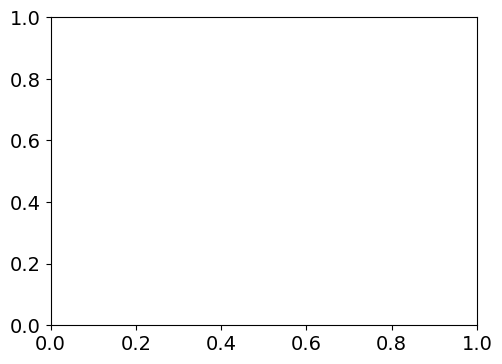

In [16]:
ax = plt.gca()

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.contour(XX, YY, ZZ, levels=[low_B, upp_B], colors=['w', 'w']);

set_A = patches.Rectangle((low_x, low_y), upp_x-low_x, upp_y-low_y, color='k',
                          fill=None, zorder=10, linewidth=2.5)
ax.add_patch(set_A)

plt.text(upp_x-0.002, low_y-0.04, r'$A$', fontsize=16)
plt.text(upp_x-0.006, upp_y+0.1, r'$Q^{-1}(B)$', fontsize=16, color='w')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 7)])

plt.tight_layout()
# plt.savefig('/Users/kirana/Desktop/work/paper/sets_Lambda.png', bbox_inches='tight')

In [ ]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)
plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$', color='k')
plt.yticks(fontsize=14)
plt.text((upp_B-low_B)/2 + low_B, 145, r'$B$', color='r', fontsize=16,
         horizontalalignment='center', verticalalignment='center')
plt.text(low_B, 145, r'$[$', color='r', fontsize=16, horizontalalignment='center', verticalalignment='center')
plt.text(upp_B, 145, r'$]$', color='r', fontsize=16, horizontalalignment='center', verticalalignment='center')
plt.axvspan(low_B, upp_B, alpha=0.3, color='r')

plt.legend(loc='upper right', shadow=True)
plt.xlabel(r'$u$')
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)], color='k')

plt.tight_layout()
# plt.savefig('/Users/kirana/Desktop/work/paper/sets_D.png', bbox_inches='tight')

In [ ]:
bin_numbers = [16, 32, 64, 128, 256, 512, 1024, 2048]
bin_numbers = [50, 100, 150, 200, 350, 400, 450, 500]
bin_numbers = [20,  40,   60, 80,  100,  120,  140, 160]
bin_numbers = [20,  40,   60, 80,  100,  120,  140, 160]
# bin_numbers = [10,  20, 30, 40, 50, 60, 70, 80]
# bin_numbers = [10, 15, 20, 25, 30, 35, 40]
# init_samples_numbers = [5000, 10000, 15000, 20000, 25000, 35000, 40000, 45000, 50000]
init_samples_numbers = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
# init_samples_numbers = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
# init_samples_numbers = [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000]

NameError: name 'count_A' is not defined

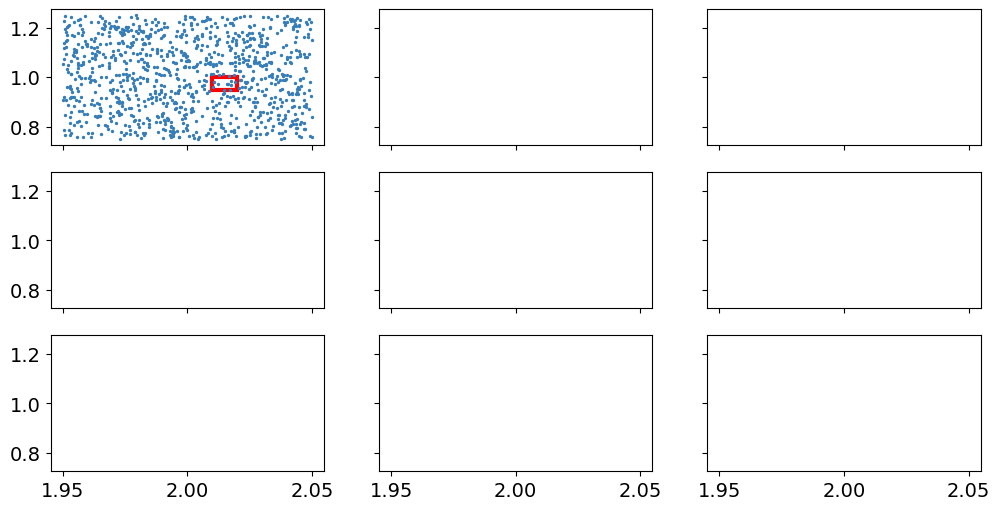

In [129]:
f, axs = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(12,6))

for i in range(3):
    for j in range(3):
        
        n_init_samples = init_samples_numbers[i * 3 + j]

        set_A = patches.Rectangle((low_x, low_y), upp_x-low_x, upp_y-low_y, color='r', fill=None, linewidth=3)
        axs[i,j].add_patch(set_A)
        axs[i,j].scatter(init_samples[:n_init_samples,0], init_samples[:n_init_samples,1], s=2)
        axs[i,j].set_title(f'Total samples = {n_init_samples}, in A = {count_A[i * 3 + j]}', fontsize=12)

# plt.savefig('/Users/kirana/Desktop/work/paper/init_samples_convergence.png')

In [ ]:
print(true_up_prob_set)
print(ccc_A[0,0]-true_up_prob_set)
print(ccc_A[-1,-1] - true_up_prob_set)

In [139]:
n_trials = 500

In [140]:
if rerun_distributions == True:

    c_A = []
    c_B = []

    for trial in range(n_trials):
        
        print(f'working on trial {trial}')

        comp_prob_A = []
        comp_prob_B = []

        init_samples_full = np.random.uniform(0, 1, (init_samples_numbers[-1], 2))
        init_samples_full[:,0] = init_samples_full[:,0] * delta_l + l - delta_l / 2
        init_samples_full[:,1] = init_samples_full[:,1] * delta_kappa + kappa - delta_kappa / 2

        pred_samples_full = np.zeros((init_samples_numbers[-1], 1))
        pred_samples_full[:, 0] = u(N, sensor_loc, t, init_samples_full[:,0], init_samples_full[:,1])

        for i, n_init_samples in enumerate(init_samples_numbers):

            comp_prob_A.append([])
            comp_prob_B.append([])

            init_samples = init_samples_full[:n_init_samples,:]

            pred_samples = pred_samples_full[:n_init_samples,:]
            pred_KDE = GKDE(pred_samples[:,0])

            for b, n_bins in enumerate(bin_numbers):
                w, bins, centers, w_center = weights.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                        pred_samples,
                                                                        targ_CDF=obs_dist.cdf,
                                                                        # sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

                weight_set = 0
                for count, psamp in enumerate(pred_samples): 
                    if psamp >= low_B and psamp <= upp_B:
                        weight_set += w[count]

                up_prob_set = 0
                for count, isamp in enumerate(init_samples):
                    if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                        up_prob_set += w[count]

                comp_prob_B[i].append(weight_set)
                comp_prob_A[i].append(up_prob_set)

        c_A.append(comp_prob_A)
        c_B.append(comp_prob_B)

    dist_prob_A = np.array(c_A)
    dist_prob_B = np.array(c_B)

    np.save('./data/convergence_qp_prob_A.npy', dist_prob_A.reshape(n_trials, -1))
    np.save('./data/convergence_qp_prob_B.npy', dist_prob_B.reshape(n_trials, -1))
    
else:

    dist_prob_A = np.load('./data/convergence_qp_prob_A.npy').reshape(n_trials,
                                                                        len(init_samples_numbers),
                                                                        len(bin_numbers))
    dist_prob_B = np.load('./data/convergence_qp_prob_B.npy').reshape(n_trials,
                                                                        len(init_samples_numbers),
                                                                        len(bin_numbers))

working on trial 0
working on trial 1
working on trial 2
working on trial 3
working on trial 4
working on trial 5
working on trial 6
working on trial 7
working on trial 8
working on trial 9
working on trial 10
working on trial 11
working on trial 12
working on trial 13
working on trial 14
working on trial 15
working on trial 16
working on trial 17
working on trial 18
working on trial 19
working on trial 20
working on trial 21
working on trial 22
working on trial 23
working on trial 24
working on trial 25
working on trial 26
working on trial 27
working on trial 28
working on trial 29
working on trial 30
working on trial 31
working on trial 32
working on trial 33
working on trial 34
working on trial 35
working on trial 36
working on trial 37
working on trial 38
working on trial 39
working on trial 40
working on trial 41
working on trial 42
working on trial 43
working on trial 44
working on trial 45
working on trial 46
working on trial 47
working on trial 48
working on trial 49
working on

In [141]:
ccc_A = np.mean(dist_prob_A, axis=0)
ccc_B = np.mean(dist_prob_B, axis=0)

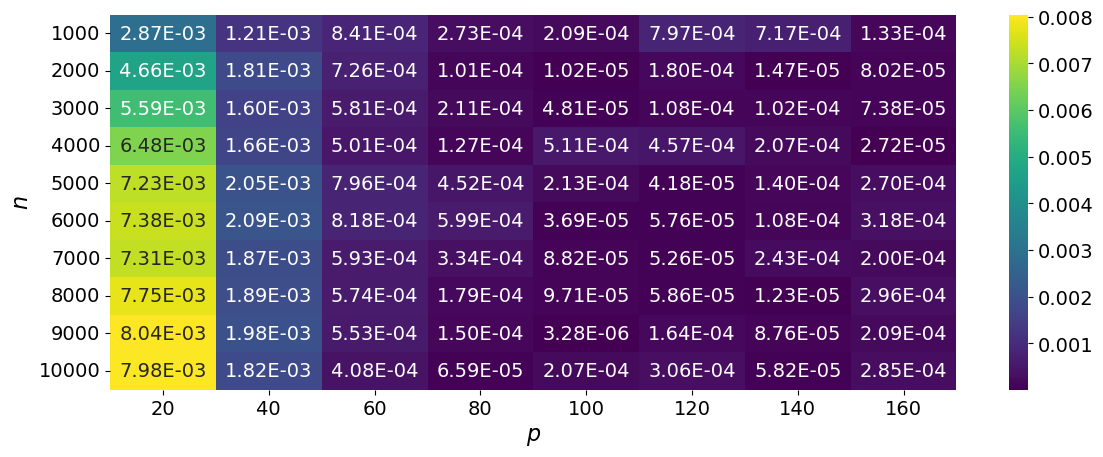

In [164]:
plt.figure(figsize=(12,4.8))

# s = sns.heatmap(np.abs(np.array(ccc_B)-obs_prob_set), annot=True, cmap='viridis', fmt='0.2E',
#             yticklabels=init_samples_numbers, xticklabels=bin_numbers,
#             norm=colors.LogNorm(vmin=np.min(np.abs(np.array(ccc_B)-obs_prob_set)),
#                                 vmax=np.max(np.abs(np.array(ccc_B)-obs_prob_set))));
s = sns.heatmap(np.abs(np.array(ccc_B)-obs_prob_set), annot=True, cmap='viridis', fmt='0.2E',
            yticklabels=init_samples_numbers, xticklabels=bin_numbers);

s.set_xlabel('$p$')
s.set_ylabel('$n$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/heatmap_meanB.png', bbox_inches='tight')

In [143]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for ii, b in enumerate(ccc_B):
    row_string = f'{init_samples_numbers[ii]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of B = {obs_prob_set:.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.26769  0.26814  0.26824  0.26839  0.26841  0.26868  0.26865  0.26850  
 2000   0.26721  0.26798  0.26827  0.26843  0.26846  0.26841  0.26847  0.26848  
 3000   0.26696  0.26803  0.26831  0.26841  0.26845  0.26849  0.26843  0.26844  
 4000   0.26672  0.26802  0.26833  0.26843  0.26860  0.26858  0.26852  0.26847  
 5000   0.26652  0.26791  0.26825  0.26834  0.26852  0.26847  0.26850  0.26839  
 6000   0.26648  0.26790  0.26824  0.26830  0.26845  0.26845  0.26849  0.26838  
 7000   0.26650  0.26796  0.26830  0.26837  0.26849  0.26848  0.26853  0.26841  
 8000   0.26638  0.26795  0.26831  0.26841  0.26849  0.26845  0.26847  0.26838  
 9000   0.26630  0.26793  0.26831  0.26842  0.26846  0.26851  0.26849  0.26841  
10000   0.26632  0.26797  0.26835  0.26844  0.26852  0.26854  0.26848  0.26839  

actual probability of B = 0.26846


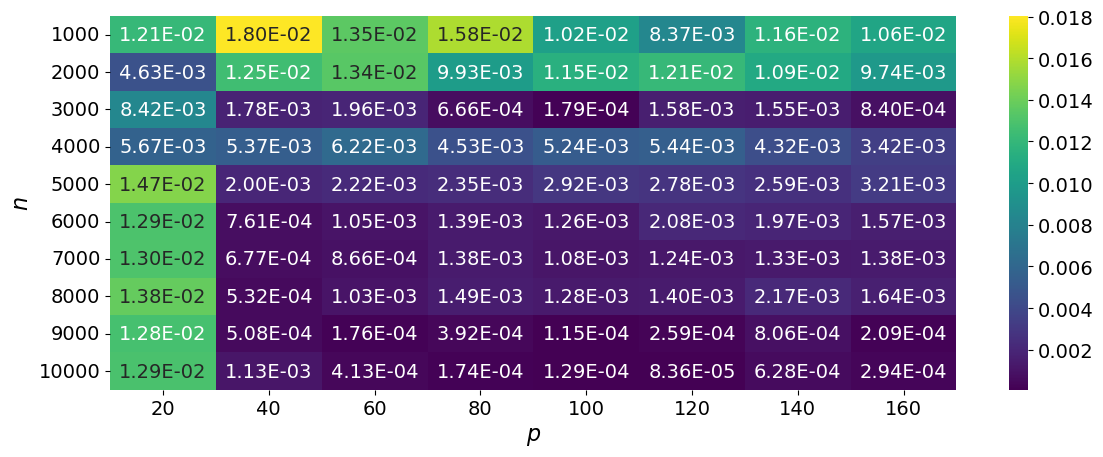

In [165]:
plt.figure(figsize=(12,4.8))

# s = sns.heatmap(np.abs(np.array(ccc_A)-true_up_prob_set), annot=True, cmap='viridis', fmt='0.2E',
#                 yticklabels=init_samples_numbers, xticklabels=bin_numbers,
#                 norm=colors.LogNorm(vmin=np.min(np.abs(np.array(ccc_A)-true_up_prob_set)),
#                                     vmax=np.max(np.abs(np.array(ccc_A)-true_up_prob_set))));
s = sns.heatmap(np.abs(np.array(ccc_A)-true_up_prob_set)/true_up_prob_set, annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=init_samples_numbers, xticklabels=bin_numbers);


s.set_xlabel('$p$')
s.set_ylabel('$n$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/heatmap_meanA.png', bbox_inches='tight')

In [153]:
true_up_prob_set = 0.01965
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for ii, b in enumerate(ccc_A):
    row_string = f'{init_samples_numbers[ii]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of A = {true_up_prob_set:.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.01989  0.02000  0.01992  0.01996  0.01985  0.01981  0.01988  0.01986  
 2000   0.01974  0.01990  0.01991  0.01985  0.01988  0.01989  0.01986  0.01984  
 3000   0.01948  0.01969  0.01969  0.01966  0.01965  0.01968  0.01962  0.01963  
 4000   0.01954  0.01976  0.01977  0.01974  0.01975  0.01976  0.01973  0.01972  
 5000   0.01936  0.01961  0.01961  0.01960  0.01959  0.01960  0.01960  0.01959  
 6000   0.01940  0.01964  0.01963  0.01962  0.01963  0.01961  0.01961  0.01962  
 7000   0.01939  0.01964  0.01963  0.01962  0.01963  0.01963  0.01962  0.01962  
 8000   0.01938  0.01964  0.01963  0.01962  0.01962  0.01962  0.01961  0.01962  
 9000   0.01940  0.01966  0.01965  0.01964  0.01965  0.01964  0.01963  0.01965  
10000   0.01940  0.01967  0.01964  0.01965  0.01965  0.01965  0.01964  0.01964  

actual probability of A = 0.01965


In [150]:
cccc_A = np.std(dist_prob_A, axis=0)
cccc_B = np.std(dist_prob_B, axis=0)

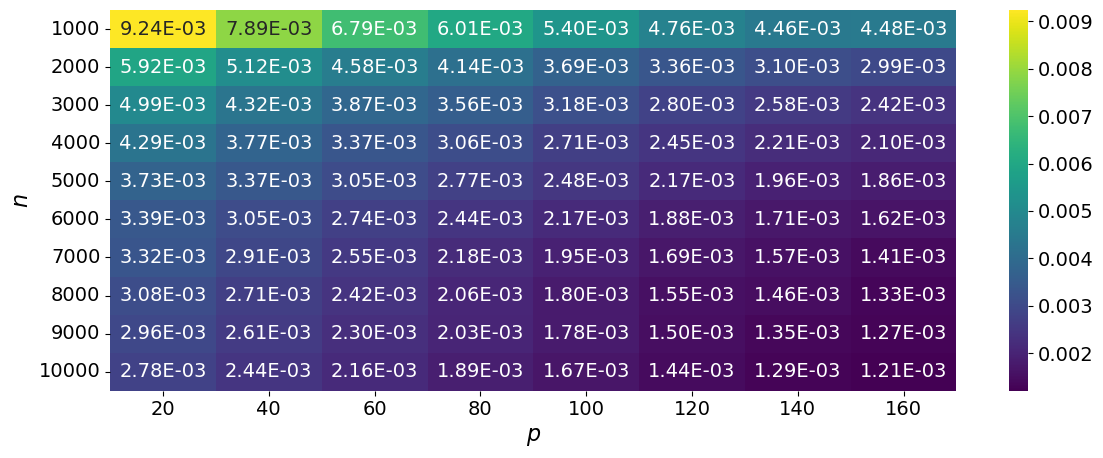

In [151]:
plt.figure(figsize=(12,4.8))

s = sns.heatmap(np.abs(np.array(cccc_B)), annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=init_samples_numbers, xticklabels=bin_numbers);

s.set_xlabel('$p$')
s.set_ylabel('$n$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/heatmap_stdB.png', bbox_inches='tight')

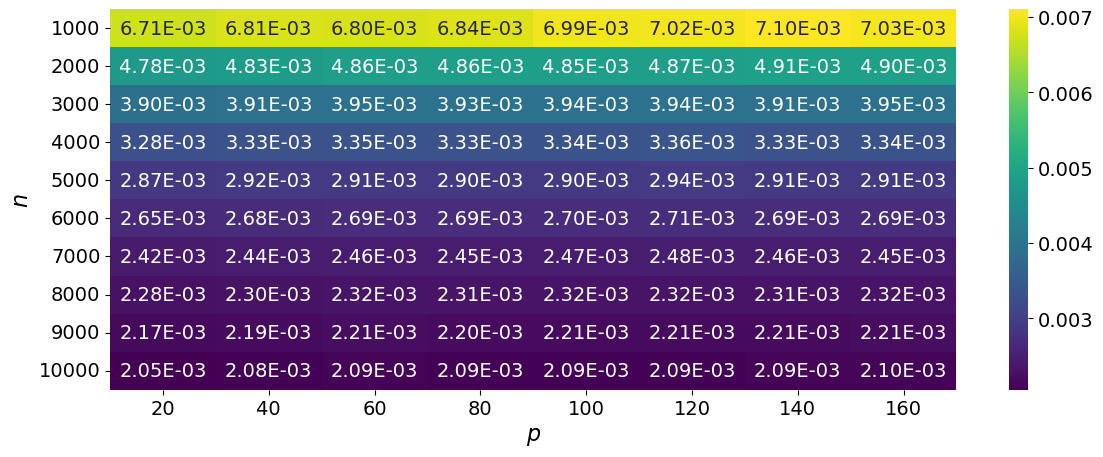

In [148]:
plt.figure(figsize=(12,4.8))

s = sns.heatmap(np.abs(np.array(cccc_A)), annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=init_samples_numbers, xticklabels=bin_numbers);
s.set_xlabel('$p$')
s.set_ylabel('$n$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/heatmap_stdA.png', bbox_inches='tight')